# Logistic and linear regression with deterministic and stochastic first order methods



    Lab 2 : Optimisation - DataScience Master
    Authors : Alexandre Gramfort, Hicham Janati
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, even non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**, please
  check the deadline on moodle.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [45]:
# Change here using YOUR first and last names
fn1 = "liyao"
ln1 = "jiao"
fn2 = "yuanjie"
ln2 = "zhao"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_jiao_liyao_and_zhao_yuanjie.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [46]:
%matplotlib inline

In [47]:
from time import time

import numba
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

from numba import njit

# np.random.seed(43)

In [48]:
# choose a large font size by default and use tex for math
usetex = False  # change this to True if you have a working LaTeX install

fontsize = 16
params = {
    "axes.labelsize": fontsize + 2,
    "font.size": fontsize + 2,
    "legend.fontsize": fontsize + 2,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "text.usetex": usetex,
}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [49]:
print(numba.__version__) # Your version of Numba

0.60.0


In [50]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
x = x.astype(float)
go_fast(x) # Running a first time the function to compile it

array([[  9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.],
       [ 19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.],
       [ 29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.],
       [ 39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.],
       [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.],
       [ 59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.],
       [ 69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.],
       [ 79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.],
       [ 89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.],
       [ 99., 100., 101., 102., 103., 104., 105., 106., 107., 108.]])

In [51]:
np.tanh(0)+ np.tanh(10) + np.tanh(20)

1.9999999958776926

Iteration time of the Numba-compiled function.

In [52]:
# %timeit go_fast(x)

Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [53]:
# %timeit go_fast.py_func(x)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For each cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for least-squares regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [54]:
d = 50
n = 10000

In [55]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [56]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [57]:
from numpy.random import multivariate_normal, randn
from scipy.linalg import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [58]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [59]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

<StemContainer object of 3 artists>

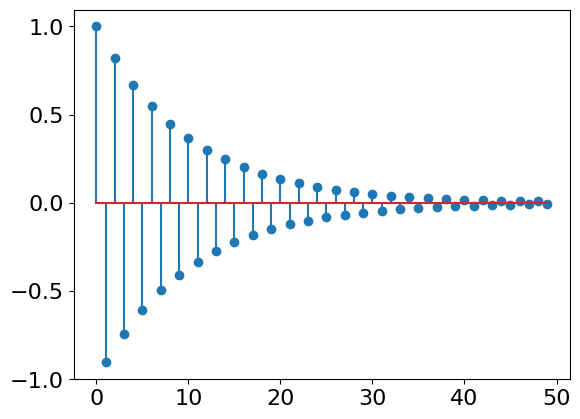

In [60]:
plt.stem(x_model_truth)

### Numerically check loss and gradient

In [61]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

6.982648604091837e-06

In [62]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.1791996020206736e-07

### Choice of the model

In [63]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [64]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06166602670158778


### Get a very precise minimum to compute distances to minimum

Here we use L-BFGS that you have not seen yet. Just take the estimated `x_min` and move on.
You will see L-BFGS later in the course.

In [65]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5220967248849355
6.848516409846131e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD)

### Define a class to monitor iterations

In [66]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [67]:
# Number of iterations
n_iter = 200

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [68]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x -= step * grad(x, *args)
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [69]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipschitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [70]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, *args)
        t_new = (1. + (1. + 4. * t**2)**0.5) / 2.
        y_new = x_new + (t - 1) / t_new * (x_new - x)
        x, y, t = x_new, y_new, t_new
        ### END TODO
    return x, x_list

In [71]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [72]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers, xscale='linear', yscale='log'):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")
        plt.yscale(yscale)
        plt.xscale(xscale)

    plt.legend(solvers)

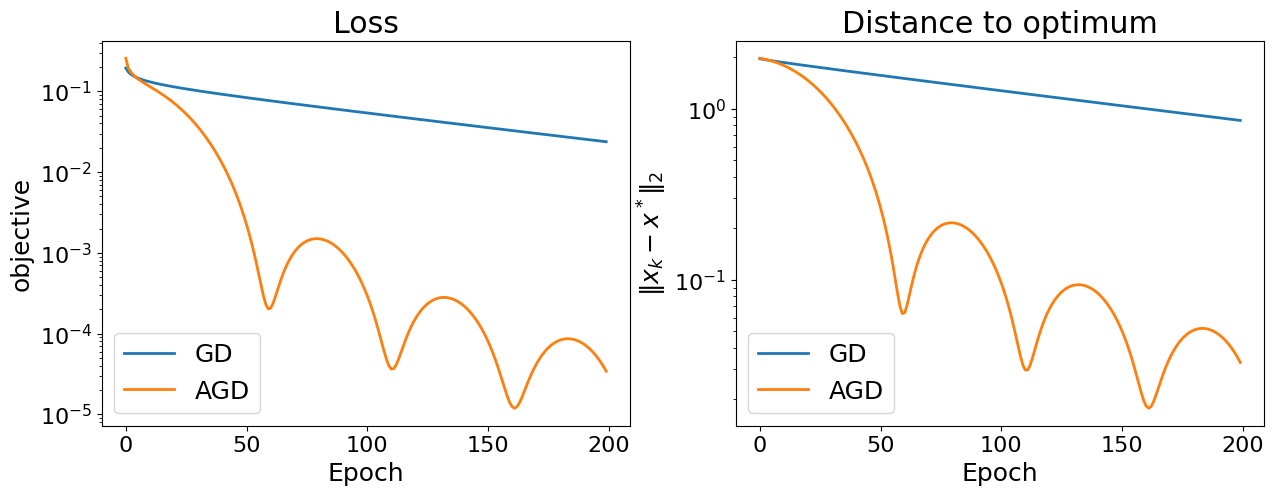

In [73]:
monitors = [monitor_gd, monitor_agd]

solvers = ["GD", "AGD"]

plot_epochs(monitors, solvers)

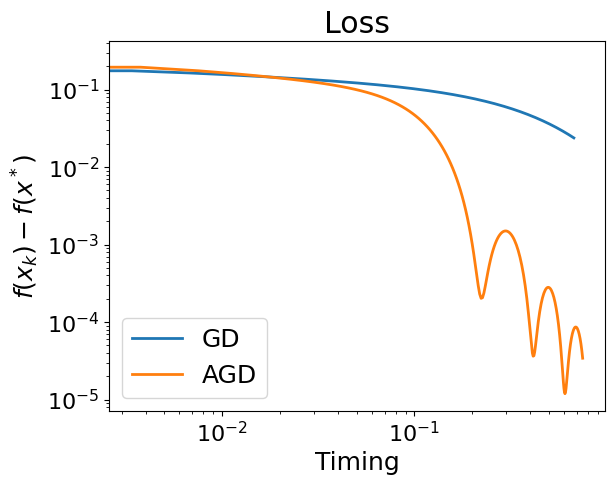

In [74]:
plot_time(monitors, solvers, xscale='log')

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

> We observe that AGD converges faster than GD, but it fluctuates more and shows recurring variations. AGD often uses a momentum term, which incorporates previous gradient information to speed up convergence, resulting to the fluctuation.

<a id='stoc'></a> 
## 4. Stochastic methods

In [75]:
n_iter = 50

# generate indices of random samples
random_indices = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [76]:
@njit
def sgd(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]
        
        ### TODO
        x -= step / (idx + 1)**0.5 * grad_i(i, x, *args)
        ### END TODO
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [77]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [78]:
@njit
def sag(x_init, random_indices, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = random_indices[idx]  # i_t
        ### TODO
        new_grad = grad_i(i, x, *args)
        averaged_gradient = averaged_gradient + (new_grad - gradient_memory[i]) / n
        gradient_memory[i] = grad_i(i, x, *args)
        x -= step * averaged_gradient
        ### END TODO
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [79]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [80]:
@njit
def svrg(x_init, random_indices, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter): # k 
        ### TODO
        x = x_old.copy()
        u = grad(x, *args)
        for j in range(n):
            i = random_indices[idx * n + j]
            x -= step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + u)
        x_old = x.copy()
        ### END TODO
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [81]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))

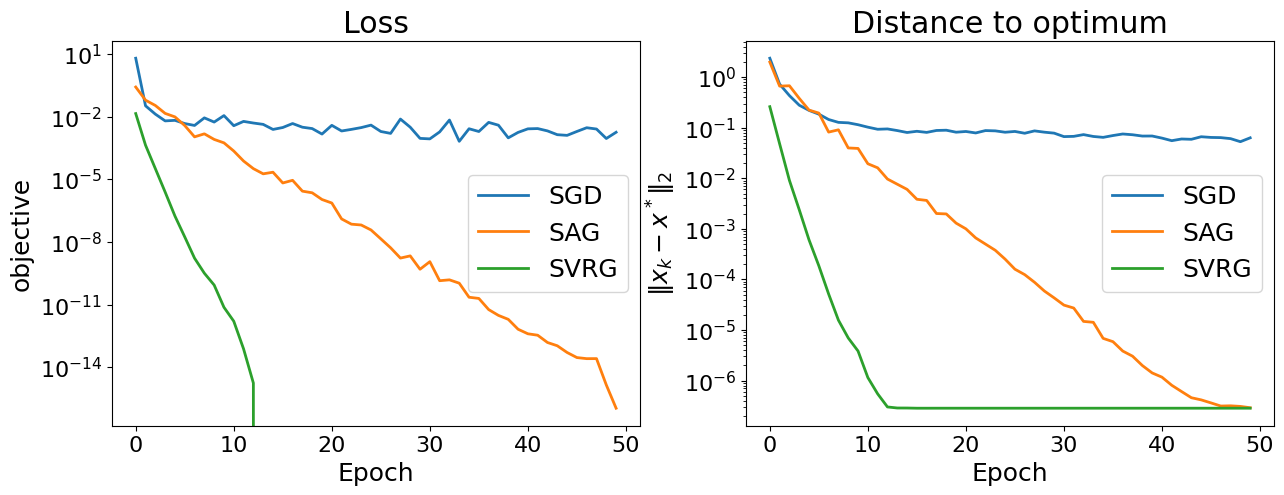

In [82]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

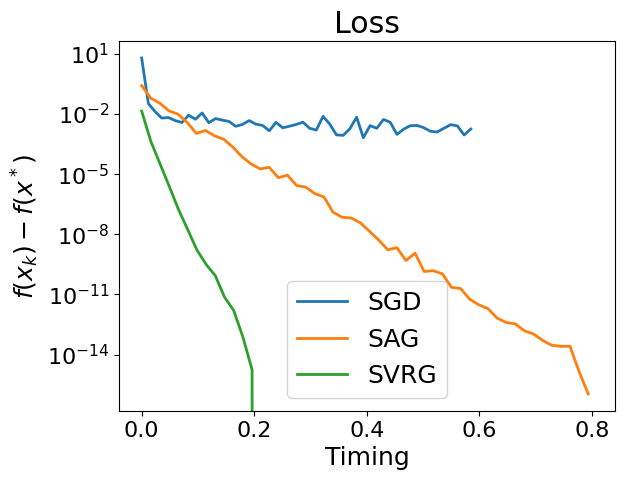

In [83]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

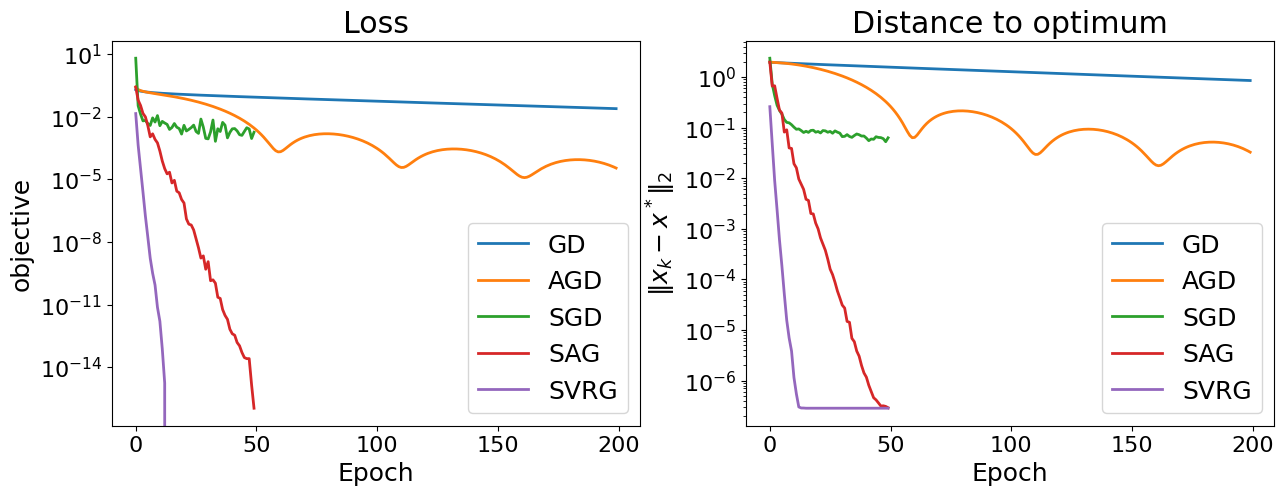

In [84]:
monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

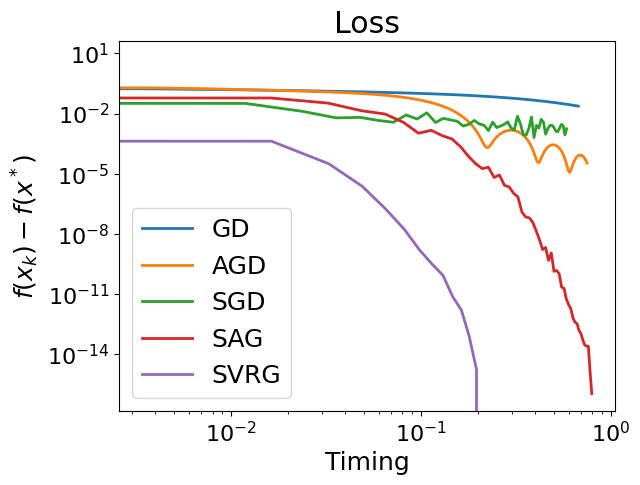

In [85]:
plot_time(monitors, solvers, xscale='log')

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

### 6.1 **Compare and comment your results**
- GD: Converges slowly with steady progress and minimal fluctuations.
- AGD: Shows faster initial convergence but experiences oscillations due to overshooting.
- SGD: Has noisy, unstable convergence, leveling off at a higher loss due to stochastic noise.
- SAG: Converges smoothly and faster than GD and SGD, aided by variance reduction.
- SVRG: Achieves the fastest and most stable convergence, reaching the lowest loss and distance to the optimum.
> SVRG is the most effective algorithm, combining speed and accuracy, followed by SAG.


In [ ]:
lbda = 1
# Number of iterations
n_iter = 200

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

n_iter = 50

# # generate indices of random samples
# random_indices = np.random.randint(0, n, n * n_iter)

step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))

monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)
plot_time(monitors, solvers, xscale='log')


### 6.2 Change $\lambda$

<span style="color:red">Full Code and Figures in Appendix A (below)</span>

<span style="color:red">Full Code and Figures in Appendix A (below)</span>

<span style="color:red">Full Code and Figures in Appendix A (below)</span>


```python
# Part of Code for analysing lambda, Full Code and Figures in Appendix A 
# Part of Code for analysing lambda, Full Code and Figures in Appendix A 
# Part of Code for analysing lambda, Full Code and Figures in Appendix A 
lbda = 1  # 1 / n
# Number of iterations
n_iter = 200

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

n_iter = 50

# # generate indices of random samples
# random_indices = np.random.randint(0, n, n * n_iter)

step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, random_indices, grad_i, n_iter * n, step0, args=(A, b, lbda))

max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, random_indices, grad_i, n_iter * n, step, args=(A, b, lbda))

x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, random_indices, grad, grad_i, n_iter, step, args=(A, b, lbda))

monitors = [monitor_gd, monitor_agd,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)
plot_time(monitors, solvers, xscale='log')
```


#### Algorithm Performance with  $\lambda = \frac{1}{n}$

With the ridge regularization parameter $\lambda$ changed from $\frac{1}{\sqrt{n}}$ to $ \frac{1}{n} $, we can see its impact on the convergence of different optimization algorithms. 

- **GD**: Slowest convergence, largely unaffected by the change in $\lambda$.
- **AGD**: Increased oscillations and reduced stability with the smaller $\lambda$.
- **SGD**: Minor precision improvements but remains noisier than SAG and SVRG.
- **SAG**: Stable, smooth, and precise convergence, unaffected by $\lambda$ reduction.
- **SVRG**: Fastest and most robust, with top performance in speed and precision.

**Overall**: SVRG and SAG emerge as the most robust and effective methods with the reduced $\lambda = \frac{1}{n}$ . SVRG leads in both convergence speed and precision.

---



#### Algorithm Performance with  $\lambda = 1$

With the ridge regularization parameter $\lambda$ set to 1, the convergence behaviors of the optimization algorithms show notable differences compared to previous settings. Here's a comparison of the updated results:

- **GD**: Slowest, with little change from the new $\lambda$.
- **AGD**: More oscillations and less stability due to the larger $\lambda$.
- **SGD**: Shows slight improvements in precision but remains less stable than SAG and SVRG.
- **SAG**: Maintains stable, precise convergence, unaffected by the larger $\lambda$.
- **SVRG**: Best choice with the fastest and most precise convergence, unaffected by $\lambda$.

**Overall**: SVRG and SAG are the most robust algorithms with the new regularization setup, while AGD is more sensitive to $\lambda$, leading to periodic oscillations.

### 6.3 Change Correlation between features

<span style="color:red">Full Code and Figures in Appendix B (below)</span>

<span style="color:red">Full Code and Figures in Appendix B (below)</span>

<span style="color:red">Full Code and Figures in Appendix B (below)</span>

#### corr = 0.1 

With the correlation reduced from 0.9 to 0.1, the algorithms show:

- **GD**: Steady but slow convergence, unaffected by correlation change.
- **AGD**: Faster than GD but with mild oscillations, indicating sensitivity to correlation.
- **SGD**: Limited improvement, fluctuates at a high objective and distance.
- **SAG**: Stable, smooth convergence, robust to lower correlation.
- **SVRG**: Best performance, with fast and precise convergence, unaffected by correlation change.

**Conclusion**: SVRG and SAG are the most robust methods with reduced correlation. AGD shows mild oscillations, while GD and SGD remain slower and less stable.

#### corr = 0.99

With the correlation value increased to 0.99 \), the algorithms show:

- **GD**: Slow and steady convergence, with minimal impact from the correlation increase.
- **AGD**: Faster than GD, now with no oscillations and a smoother convergence due to the stabilizing effect of the higher correlation.
- **SGD**: Quick initial convergence but stabilizes at a higher objective level with minor noise, likely influenced by the increased correlation.
- **SAG**: Efficient and stable convergence to a low objective level, robust to the correlation increase.
- **SVRG**: Best performance, achieving the fastest and most precise convergence with minimal oscillations, unaffected by the correlation increase.



**Conclusion**: SVRG and SAG are the most robust algorithms, demonstrating strong performance under high correlation. AGD benefits from the correlation increase, converging more smoothly without oscillations. SGD shows minor noise sensitivity, and GD remains slow but steady.

### 6.4 Conclude

Across all conditions, SVRG consistently demonstrates the best performance, achieving the fastest, most stable convergence regardless of $\lambda$ or correlation level. SAG also performs robustly, making it a reliable alternative. In contrast, AGD shows sensitivity to changes in $\lambda$
and correlation, while GD and SGD remain slower and less stable in general.